<a href="https://colab.research.google.com/github/saurabh-mathur1996/blogwebsite/blob/master/Copy_of_how_to_segment_anything_with_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os
HOME = '/content/gdrive/MyDrive/Colab_Notebooks/segment_anything'
print("HOME:", HOME)

HOME: /content/gdrive/MyDrive/Colab_Notebooks/segment_anything


## Install Segment Anything Model (SAM) and other dependencies

In [5]:
%cd $HOME

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content/gdrive/MyDrive/Colab_Notebooks/segment_anything
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rhpgb727
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rhpgb727
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [6]:
%cd $HOME
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

/content/gdrive/MyDrive/Colab_Notebooks/segment_anything


### Download SAM weights

In [7]:
%cd $HOME
!mkdir 'weights'
weights = os.path.join(HOME,'weights')
%cd $weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/gdrive/MyDrive/Colab_Notebooks/segment_anything
mkdir: cannot create directory ‘weights’: File exists
/content/gdrive/MyDrive/Colab_Notebooks/segment_anything/weights


In [8]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/gdrive/MyDrive/Colab_Notebooks/segment_anything/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [9]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

### Generate masks with SAM

In [12]:
import cv2
import supervision as sv
import matplotlib.pyplot as plt
## get all frames from video

path = '/content/gdrive/MyDrive/Colab_Notebooks/segment_anything/20230619_110140.mp4'
vidcap = cv2.VideoCapture(path)
frame_list = []
success = True
while success:
  success,image = vidcap.read()
  frame_list.append(image)
  #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  #if cv2.waitKey(10) == 27:                     # exit if Escape is hit
      #break
  #count += 1

fps = 30
#

<class 'numpy.ndarray'>
608


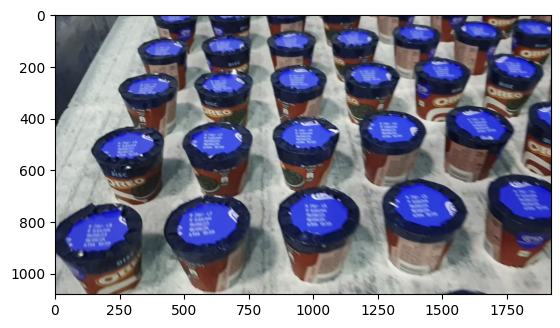

In [13]:
print(type(frame_list[0]))
import numpy as np
import matplotlib.pyplot as plt
print(len(frame_list))
temp = np.array(frame_list[0])
temp.shape
plt.imshow(frame_list[0])
#plt.imshow(org_img)
#bbox_img = cv2.rectangle(org_img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255, 255, 255), 10)
#print(bbox)
#plt.imshow(bbox_img)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [14]:
import skimage.measure
import skimage.io
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import tifffile as tf
import numpy as np
import random
import skimage
import sys
from scipy import ndimage
from skimage import io, filters, morphology, measure, segmentation
from scipy import ndimage
import numpy as np
from skimage import measure
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image

In [15]:
def boundingbox(bbox,org_img):
  img_use = np.array(org_img)
  bbox_img = cv2.rectangle(img_use, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255, 255, 255), 10)
  return bbox_img

In [16]:
file = os.path.join(HOME,'required_vid3.pdf')
pdf_pages = PdfPages(file)
frame_list_copy = frame_list.copy()
for i in range(1):
  org_img = frame_list_copy[i]
  sam_result = mask_generator.generate(org_img)
    ## generating masks
  for k in range(len(sam_result)):
    val = list(sam_result[k].values())
    img = np.array(val[0])*1
    labeled_objects = measure.label(img, background=0)
    #plt.imshow(labeled_objects)
    properties = measure.regionprops(labeled_objects)
    #print(properties.area)

    for prop in properties:
      if prop.eccentricity < 1.5 and prop.area > 10000 and prop.area < 100000:
        print(prop.eccentricity)
        print(prop.area)
        bbox = prop.bbox
        #bbox_sam = list(val[2])
        img_crop = org_img[bbox[0]:bbox[2],bbox[1]:bbox[3],:]
        plt.subplot(1,3,1)
        plt.imshow(img_crop)
        plt.title(prop.eccentricity)

        plt.subplot(1,3,2)
        from PIL import Image, ImageDraw
        image = Image.fromarray(org_img)
        draw = ImageDraw.Draw(image)
        draw.rectangle([(bbox[0],bbox[1]), (bbox[2],bbox[3])], outline='red', width=9)
        plt.imshow(image)
        plt.title(prop.area)

        plt.subplot(1,3,3)
        plt.imshow(Image.fromarray(img.astype('uint8')))
        plt.title("seg")

        pdf_pages.savefig()
        plt.close()

  pdf_pages.close()


0.5318831563407074
92483
0.3814331062572373
95313
0.6321779990588928
21359
0.72519521934912
10608
0.5319194321209589
63017
0.58378737741034
88459
0.6179218974979265
87407
0.895616204731968
53707
0.6007969353229426
57212
0.687777119777105
77450
0.8272971750138063
23417
0.5336405920311389
59037
0.27673030114715635
35900
0.5765088940783167
54679
0.4091967977281097
36639
0.2754933581276501
35900
0.5961514317721263
36140
0.3525979972916971
22488
0.578284413934719
39386
0.6592995391550402
61453
0.6502555566932708
22569
0.6371251578399109
23288
0.6017226072781869
58332
0.7504509622523198
29907
0.635586042304324
40233
0.6497309774414326
24618
0.8232105934500009
27812
0.7754673666901563
29099
0.6973528610979575
28091
0.5338561524346339
63288
0.7925810021418037
23379
0.7748131002682486
21760
0.5067393411603623
27274
0.8769092470883174
15176
0.8172235995753256
23423
0.8296197354005224
16190
0.9285649821610358
26835
0.5299629812953235
63310
0.8326410800105588
19088
0.6482534541362743
38528
0.81386

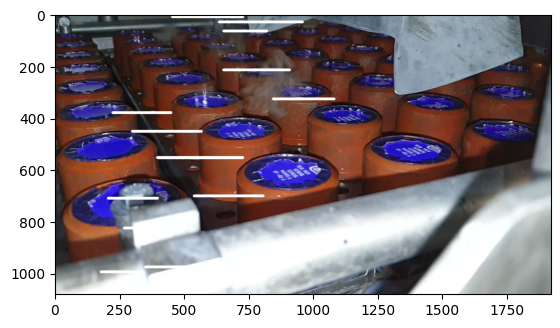

In [27]:
plt.imshow(org_img)




In [19]:
bbox_img = cv2.rectangle(org_img, (bbox[0],bbox[1]), (bbox[0]+bbox[2],bbox[1]+bbox[3]), (255, 255, 255), 10)

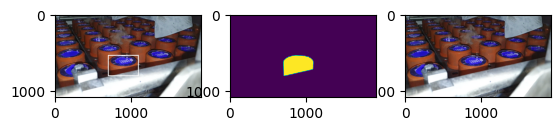

In [26]:
frame_list_copy = frame_list.copy()
org_img = frame_list_copy[0]

plt.subplot(1,3,3)
plt.imshow(org_img)

bbox = sam_result[0]['bbox']
bbox_img = cv2.rectangle(org_img, (bbox[0],bbox[1]), (bbox[0]+bbox[2],bbox[1]+bbox[3]), (255, 255, 255), 10)
plt.subplot(1,3,1)
plt.imshow(bbox_img)

plt.subplot(1,3,2)
plt.imshow(sam_result[0]['segmentation'])



In [99]:
for prop in properties:
  print(prop.area)

org_img = frame_list[i]
len(sam_result)
plt.imshow(org_img)
val[2]
print(org_img.shape)
plt.imshow(org_img[464:694,1186:1557,:])
temp = np.array(sam_result[0]['segmentation'])*1
temp.shape

80787


In [33]:
import numpy as np
img = sam_result[0]
val = list(img.values())
img = val[0]*1
labeled_objects = measure.label(img, background=0)
properties = measure.regionprops(labeled_objects)
for prop in properties:
  if prop.eccentricity < 0.3 and prop.eccentricity < 0.9:
    bbox = list(val[2])
    print(bbox)


[701, 537, 395, 266]


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

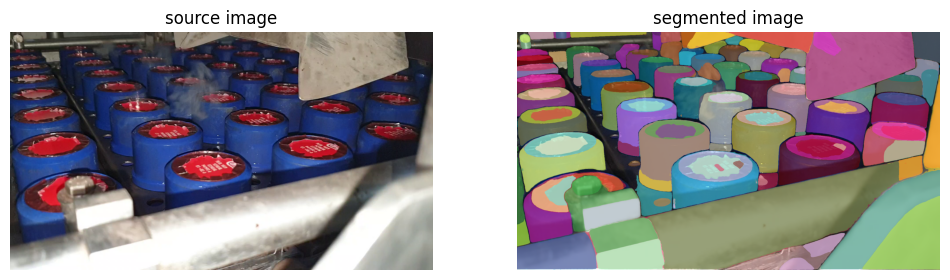

In [48]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=frame_list[0].copy(), detections=detections)

sv.plot_images_grid(
    images=[frame_list[0], annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

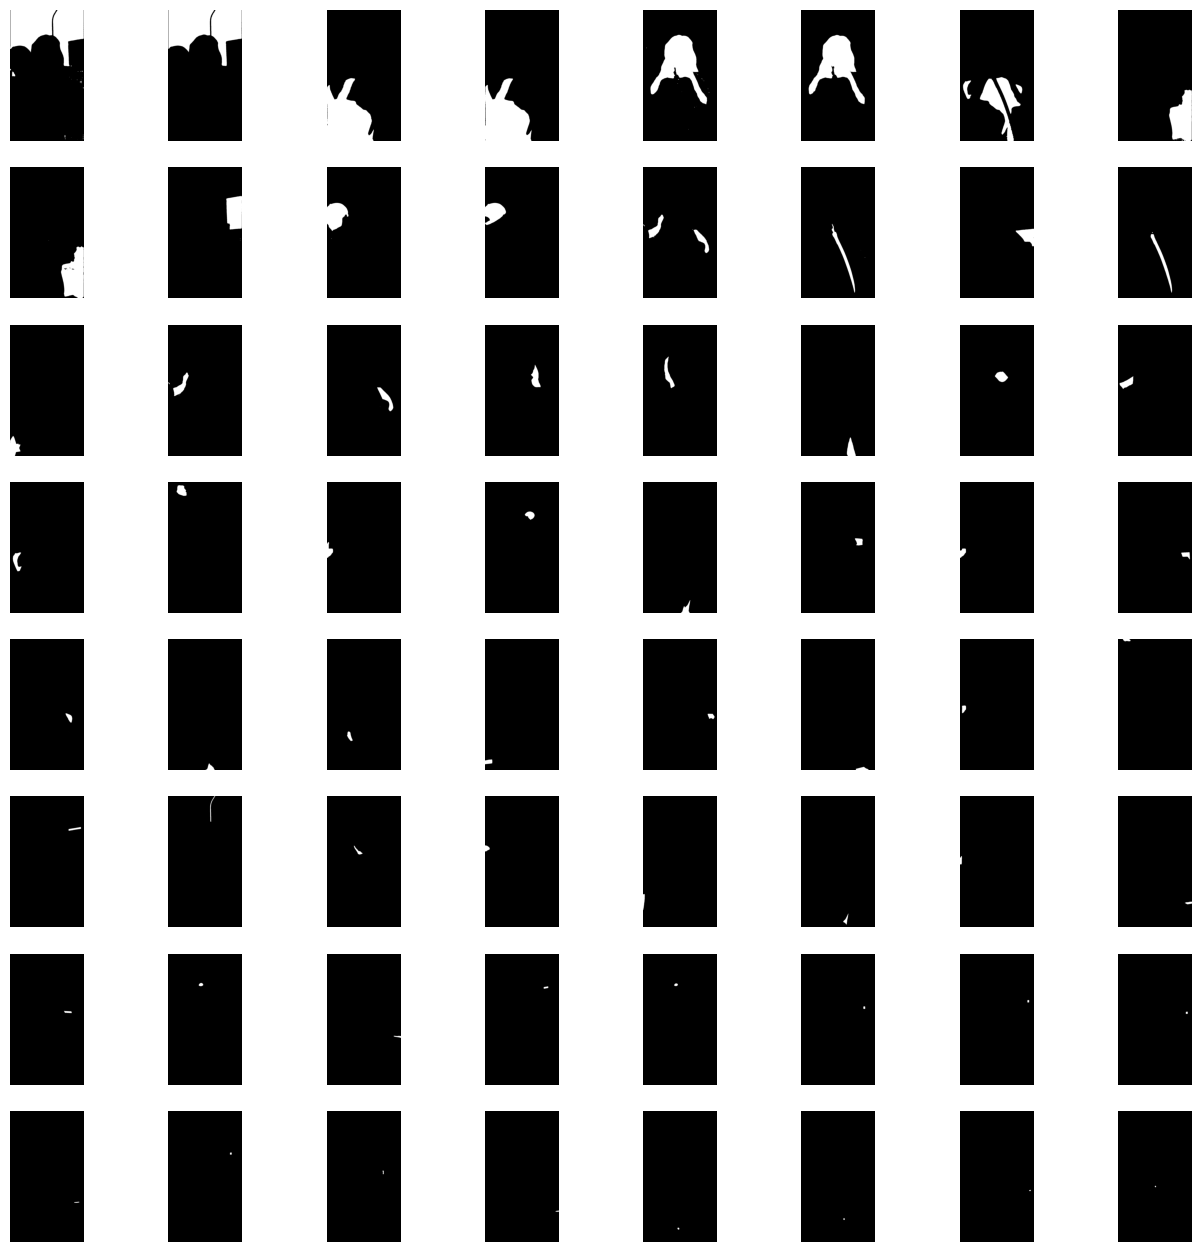

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 70, 'y': 246, 'width': 553, 'height': 678, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

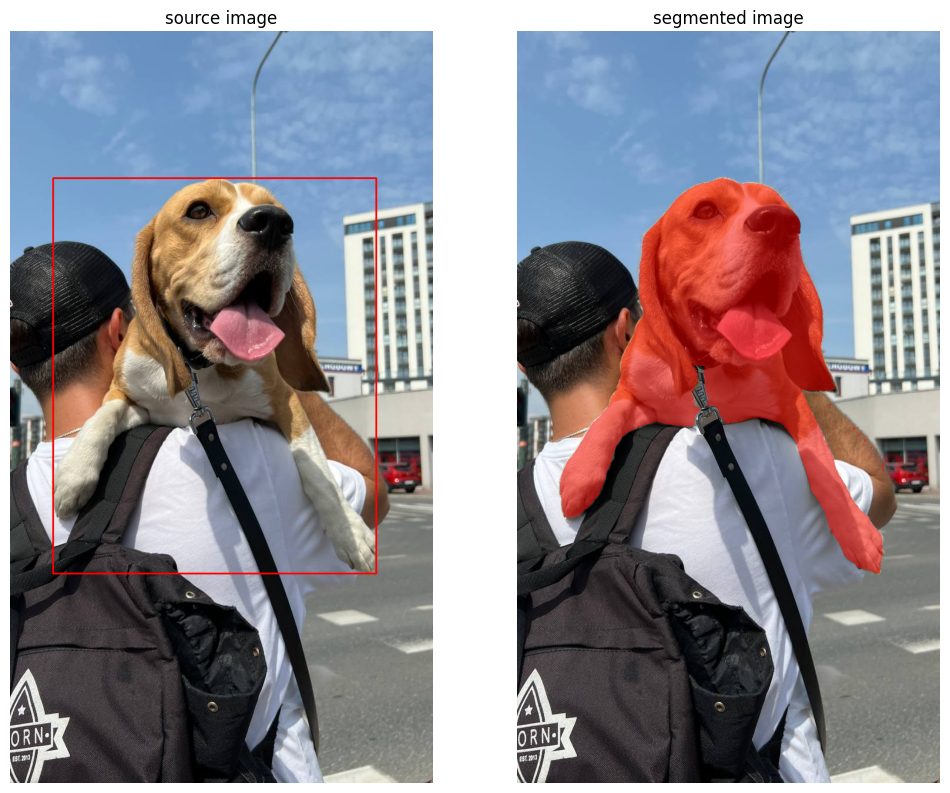

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

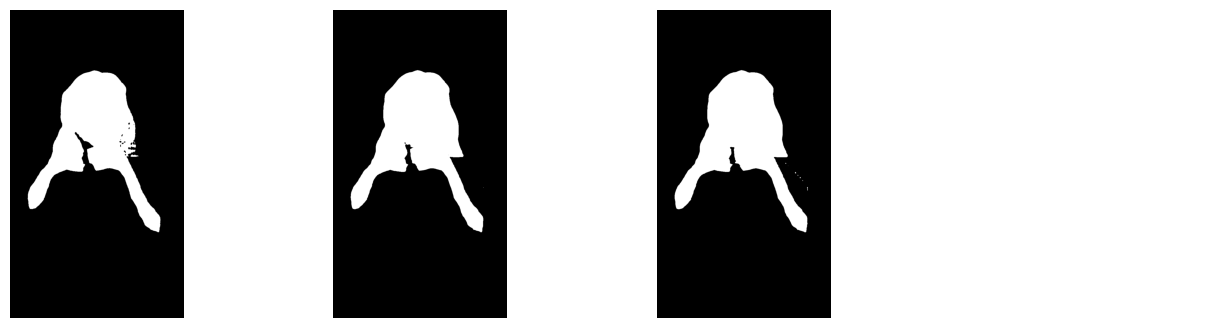

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to MRI-BRAIN-TUMOR-1 in coco:: 100%|██████████| 85/85 [00:00<00:00, 1898.83it/s]


In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['YES-TUMOR']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

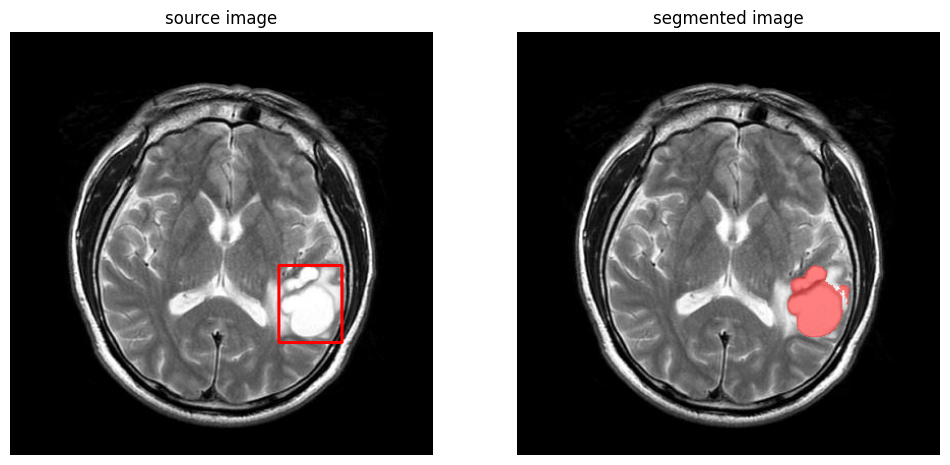

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.